<a href="https://colab.research.google.com/github/MitjaGo/YT/blob/main/ID3TAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📸 Upload a default JPG/PNG thumbnail for all MP3s:


Saving Zečić.png to Zečić (7).png


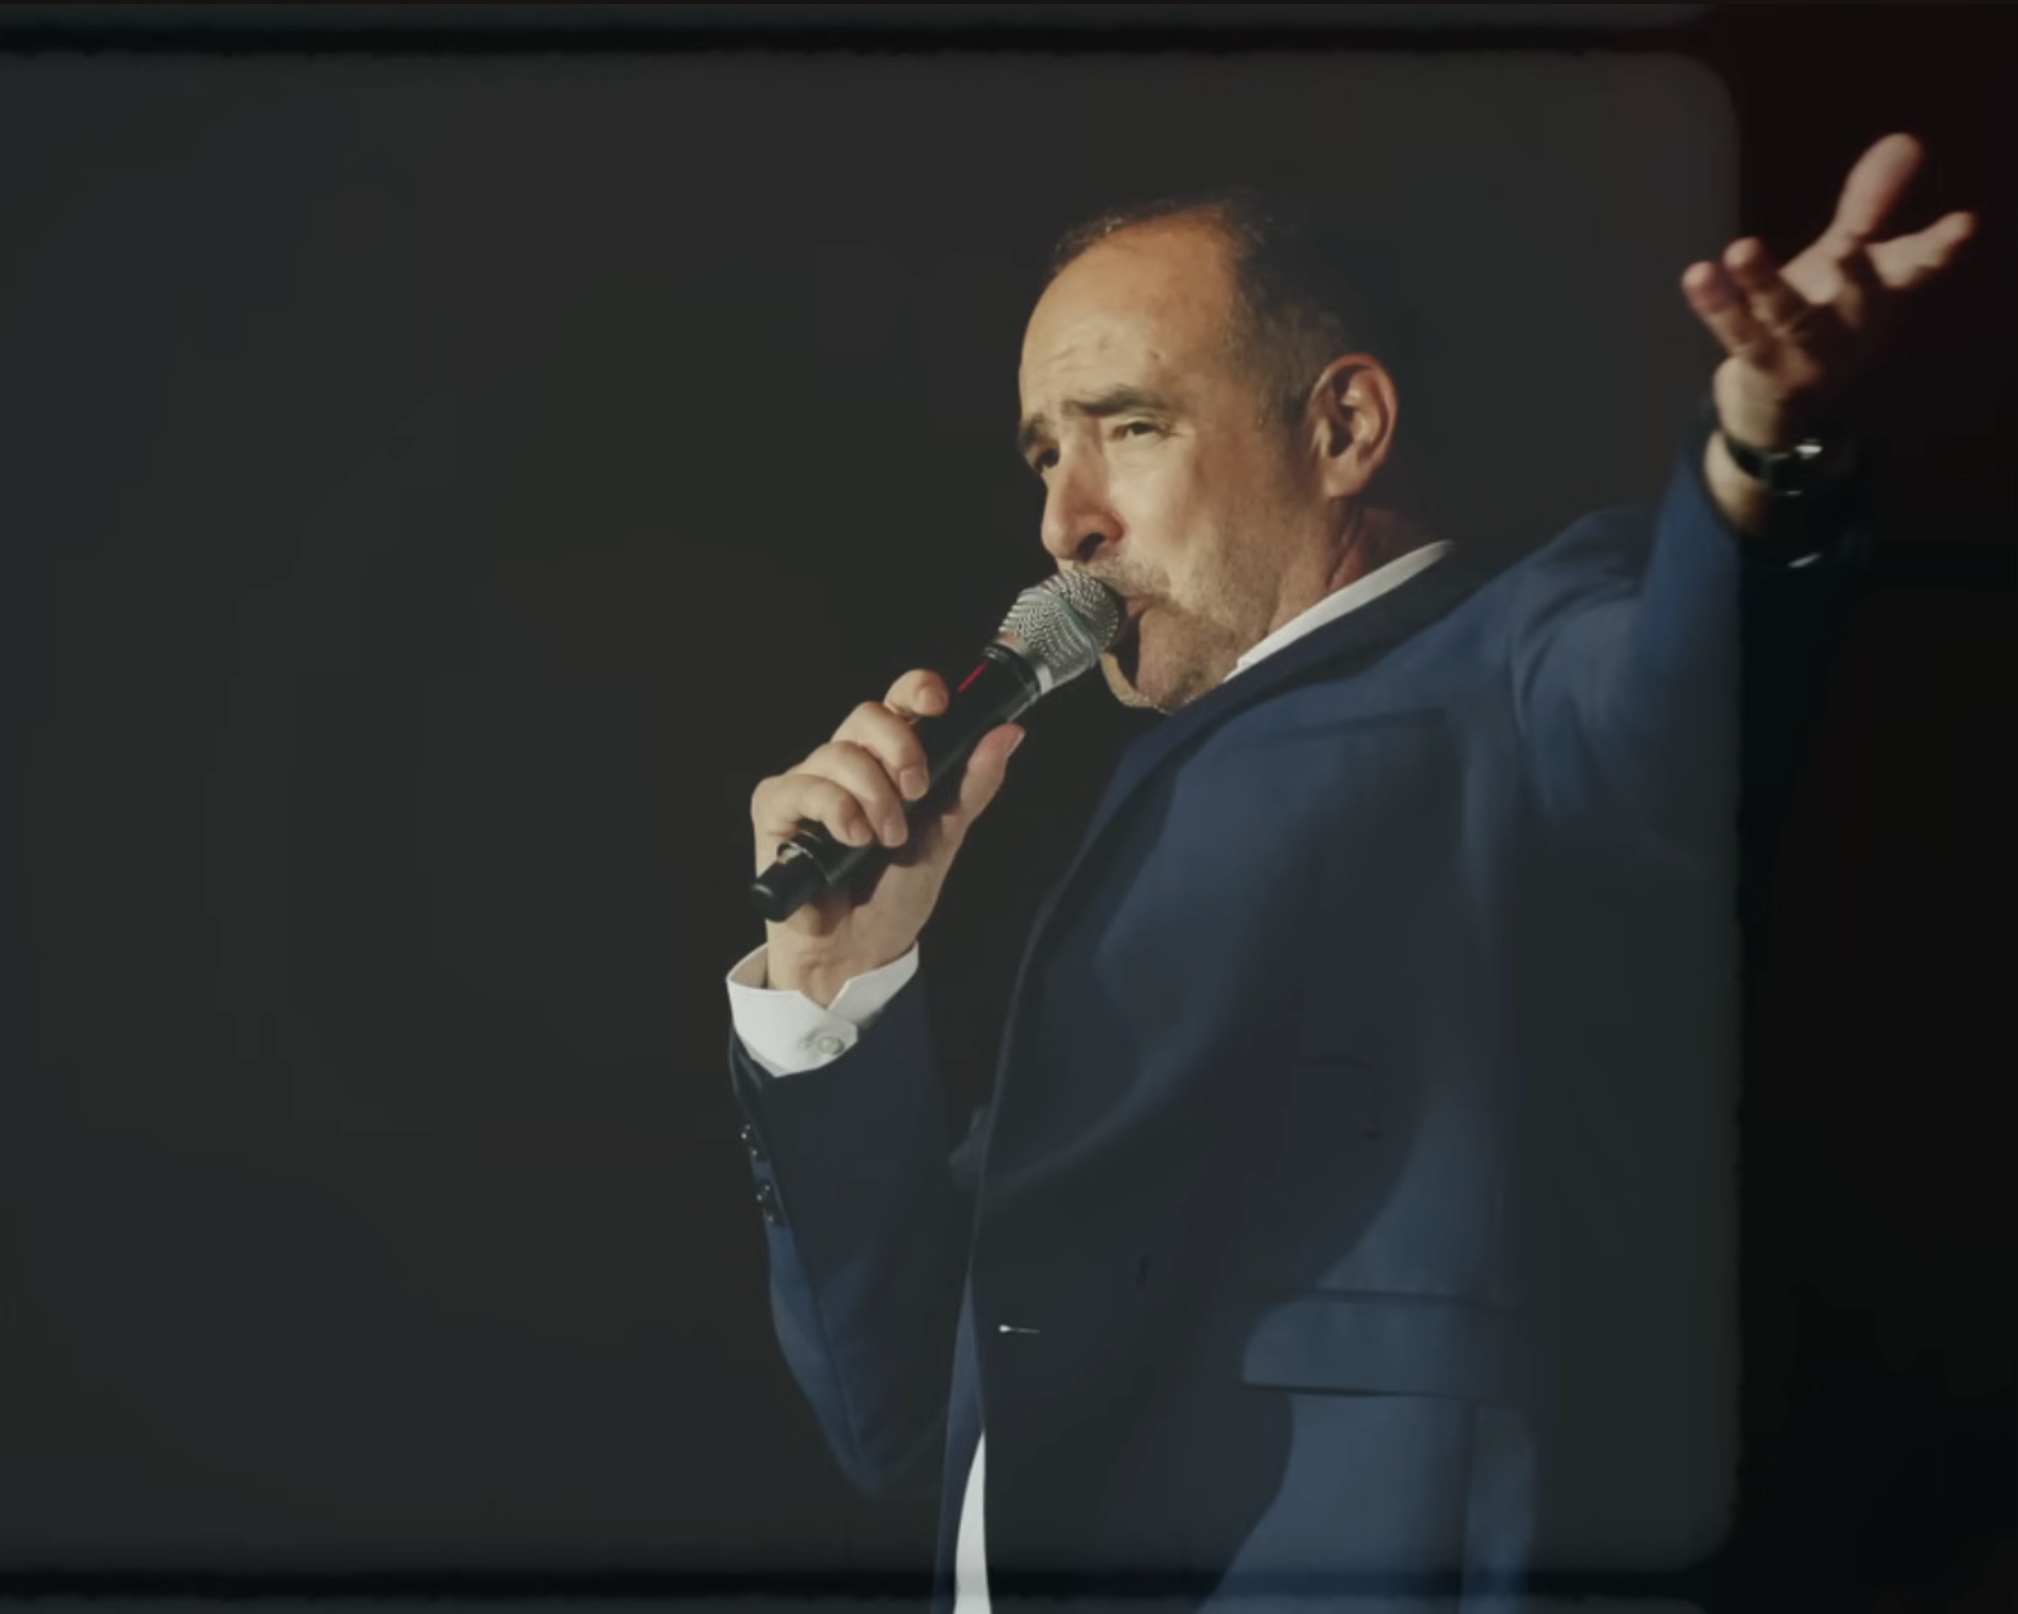


⬆️ Upload up to 50 MP3 files:


Saving 01 - Dražen Zečić - Boem U Duši.mp3 to 01 - Dražen Zečić - Boem U Duši (6).mp3
Saving 02 - Dražen Zečić - Kad Preko Mora....mp3 to 02 - Dražen Zečić - Kad Preko Mora... (6).mp3
Saving 03 - Dražen Zečič - Nitko Nema Dva Života.mp3 to 03 - Dražen Zečič - Nitko Nema Dva Života (6).mp3
Saving 04 - Dražen Zečič - Ima Li Nade Za Nas.mp3 to 04 - Dražen Zečič - Ima Li Nade Za Nas (6).mp3
Saving 05 - Što Ti Znači On.mp3 to 05 - Što Ti Znači On (6).mp3
Saving 06 - Dražen Zečič - Što Će Meni.mp3 to 06 - Dražen Zečič - Što Će Meni (6).mp3
Saving 07 - Dražen Zečič - Sokole.mp3 to 07 - Dražen Zečič - Sokole (6).mp3
Saving 08 - Dražen Zečič - Stani Srce.mp3 to 08 - Dražen Zečič - Stani Srce (6).mp3
Saving 09 - Dražen Zečič - Govore Mi Mnogi Ljudi.mp3 to 09 - Dražen Zečič - Govore Mi Mnogi Ljudi (5).mp3
Saving 10 - Dražen Zečič - Malo Je.mp3 to 10 - Dražen Zečič - Malo Je (6).mp3
✅ Uploaded 10 MP3 files.
🖼️ Default thumbnail embe

Label(value='📝 Edit MP3 Tags and optionally upload new thumbnails:')

Button(button_style='success', description='💾 Save All Tags', style=ButtonStyle())

Button(button_style='info', description='⬇️ Download All MP3s as ZIP', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Install dependencies
!pip install eyed3 ipywidgets pillow

import eyed3
from google.colab import files
from IPython.display import display, Image
import ipywidgets as widgets
import zipfile
from datetime import datetime
import re
from PIL import Image as PILImage
import io

# -------------------------------------------
# STEP 1: Upload default thumbnail
# -------------------------------------------
print("📸 Upload a default JPG/PNG thumbnail for all MP3s:")
image_upload = files.upload()
img_name, default_img_data = next(iter(image_upload.items()))
display(Image(data=default_img_data, width=150))

# -------------------------------------------
# STEP 2: Resize image for maximum compatibility
# -------------------------------------------
def resize_jpeg(img_data, max_size=500):
    img = PILImage.open(io.BytesIO(img_data))
    img.thumbnail((max_size, max_size))
    out = io.BytesIO()
    img.convert("RGB").save(out, format='JPEG', quality=85)
    return out.getvalue()

default_img_data = resize_jpeg(default_img_data)

# -------------------------------------------
# STEP 3: Upload MP3 files
# -------------------------------------------
print("\n⬆️ Upload up to 50 MP3 files:")
upload = files.upload()
mp3_files = list(upload.keys())[:50]
print(f"✅ Uploaded {len(mp3_files)} MP3 files.")

# -------------------------------------------
# Helper function: Embed thumbnail with eyeD3
# -------------------------------------------
def embed_thumbnail_eyed3(mp3_file, image_data):
    audiofile = eyed3.load(mp3_file)
    if audiofile.tag is None:
        audiofile.initTag()
    # Remove existing images
    audiofile.tag.images.set(3, image_data, "image/jpeg", u"Cover")
    audiofile.tag.save(version=eyed3.id3.ID3_V2_3)

# Apply default thumbnail to all files first
for f in mp3_files:
    embed_thumbnail_eyed3(f, default_img_data)
print("🖼️ Default thumbnail embedded into all MP3 files.")

# -------------------------------------------
# STEP 4: Create editable widgets per file
# -------------------------------------------
file_widgets = []

for f in mp3_files:
    audiofile = eyed3.load(f)
    if audiofile.tag is None:
        audiofile.initTag()
    title = audiofile.tag.title or ""
    artist = audiofile.tag.artist or ""
    album = audiofile.tag.album or ""

    title_widget = widgets.Text(value=title, description='Title:', layout=widgets.Layout(width='250px'))
    artist_widget = widgets.Text(value=artist, description='Artist:', layout=widgets.Layout(width='250px'))
    album_widget = widgets.Text(value=album, description='Album:', layout=widgets.Layout(width='250px'))
    img_widget = widgets.Image(value=default_img_data, format='jpeg', width=80, height=80)

    new_img_data = {'data': None}  # store per-file thumbnail

    # Button to upload per-file thumbnail
    def make_upload_callback(img_w, store):
        def on_upload(change):
            uploaded = files.upload()
            if uploaded:
                _, data = next(iter(uploaded.items()))
                data_resized = resize_jpeg(data)
                img_w.value = data_resized
                store['data'] = data_resized
        return on_upload

    upload_btn = widgets.Button(description="📤 Change Thumbnail", layout=widgets.Layout(width='150px'))
    upload_btn.on_click(make_upload_callback(img_widget, new_img_data))

    hbox = widgets.HBox([img_widget, widgets.Label(f, layout=widgets.Layout(width='200px')),
                         title_widget, artist_widget, album_widget, upload_btn])
    file_widgets.append((f, title_widget, artist_widget, album_widget, img_widget, new_img_data, hbox))

display(widgets.Label("📝 Edit MP3 Tags and optionally upload new thumbnails:"))
for w in file_widgets:
    display(w[-1])

# -------------------------------------------
# STEP 5: Save & Download buttons
# -------------------------------------------
save_btn = widgets.Button(description="💾 Save All Tags", button_style='success')
zip_btn  = widgets.Button(description="⬇️ Download All MP3s as ZIP", button_style='info')
output   = widgets.Output()
display(save_btn, zip_btn, output)

# -------------------------------------------
# Helper: Clean filenames (remove numbers in brackets)
# -------------------------------------------
def clean_filename(filename):
    return re.sub(r"\s*\(\d+\)(?=\.\w+$)", "", filename)

# -------------------------------------------
# Save button function
# -------------------------------------------
def on_save_clicked(b):
    for f, title_w, artist_w, album_w, img_w, new_img, _ in file_widgets:
        audiofile = eyed3.load(f)
        if audiofile.tag is None:
            audiofile.initTag()
        # Update metadata
        audiofile.tag.title = title_w.value.strip() or None
        audiofile.tag.artist = artist_w.value.strip() or None
        audiofile.tag.album = album_w.value.strip() or None
        # Embed thumbnail
        embed_thumbnail_eyed3(f, new_img['data'] if new_img['data'] else default_img_data)
    with output:
        output.clear_output()
        print("✅ All MP3 tags and thumbnails updated successfully!")

# -------------------------------------------
# ZIP download button function
# -------------------------------------------
def on_zip_clicked(b):
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_name = f"edited_mp3s_{now}.zip"
    with zipfile.ZipFile(zip_name, "w") as z:
        for f, *_ in file_widgets:
            new_name = clean_filename(f)
            z.write(f, arcname=new_name)
    files.download(zip_name)

save_btn.on_click(on_save_clicked)
zip_btn.on_click(on_zip_clicked)
